# 🌟Initializing Phase

In this section, we initialize the hyper parameters and load the training data

In [ ]:
import random, numpy as np, matplotlib.pyplot as plt, time, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import time

### Seed Control

In [ ]:
import random
import numpy as np
import torch

SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Random sample (Python):", random.random())
print("Random sample (NumPy):", np.random.rand())
print("Random sample (PyTorch):", torch.rand(1).item())

Random sample (Python): 0.8347577610922152
Random sample (NumPy): 0.8233890742543671
Random sample (PyTorch): 0.7876027822494507


### Set Hyper Parameters



In [ ]:
# According to the paper
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LR_MILESTONES = [30, 60, 90]  # decayed by every 30 epochs
LR_GAMMA = 0.1  # "decayed by 0.1" (multiply lr by 0.1)

### Load Food-101 Data

In [ ]:
import os
import json
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# =======================================================
# 控制是否強制重算
# =======================================================
USE_PRECOMPUTED_STATS = True
STATS_FILE = "food101_stats.json"

# =======================================================
# 1. 計算 food-101 mean & std ，如果已有 stats.json 直接讀取
# =======================================================

if USE_PRECOMPUTED_STATS and os.path.exists(STATS_FILE):
    print(f"[INFO] Loading precomputed stats from {STATS_FILE} ...")

    with open(STATS_FILE, "r") as f:
        stats = json.load(f)

    food101_mean = stats["mean"]
    food101_std = stats["std"]

    print("Loaded mean:", food101_mean)
    print("Loaded std :", food101_std)

else:
    print("[INFO] Computing mean/std for Food-101 (this may take a while)...")

    stats_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    food101_train_for_stats = datasets.Food101(
        root='./data',
        split='train',
        download=True,
        transform=stats_transform,
    )

    # batch_size=1 避免 Collate Error
    stats_loader = data.DataLoader(
        food101_train_for_stats,
        batch_size=1,
        shuffle=False,
        num_workers=0,
    )

    def compute_mean_std(loader):
        channel_sum = torch.zeros(3)
        channel_sq_sum = torch.zeros(3)
        total_pixels = 0

        for imgs, _ in loader:
            imgs = imgs.squeeze(0)   # [C, H, W]
            c, h, w = imgs.shape
            pixels = h * w

            channel_sum += imgs.sum(dim=[1, 2])
            channel_sq_sum += (imgs ** 2).sum(dim=[1, 2])
            total_pixels += pixels

        mean = channel_sum / total_pixels
        std = torch.sqrt(channel_sq_sum / total_pixels - mean**2)
        return mean, std

    food101_mean, food101_std = compute_mean_std(stats_loader)

    food101_mean = food101_mean.tolist()
    food101_std = food101_std.tolist()

    print("Computed mean:", food101_mean)
    print("Computed std :", food101_std)

    # =======================================================
    # 存成 JSON，之後就不用再跑了
    # =======================================================
    stats = {
        "mean": food101_mean,
        "std": food101_std
    }

    with open(STATS_FILE, "w") as f:
        json.dump(stats, f, indent=2)

    print(f"[INFO] Saved mean/std to {STATS_FILE}")

In [ ]:
# =======================================================
# 2. Official training transforms (ImageNet-style augmentation)
# =======================================================

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=food101_mean, std=food101_std),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=food101_mean, std=food101_std),
])

# =======================================================
# 3. Load Food-101 dataset
# =======================================================

trainset = datasets.Food101(
    root='./data',
    split='train',
    download=False,
    transform=train_transform,
)

testset = datasets.Food101(
    root='./data',
    split='test',
    download=False,
    transform=valid_transform,
)

train_iterator = data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

test_iterator = data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

# =======================================================
# 4. Sanity check
# =======================================================

images, labels = next(iter(train_iterator))
print(f"Train samples: {len(trainset)}")
print(f"Test samples:  {len(testset)}")
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

# 🌟Model Define: SCConv

In this section, we define our PyTorch model! After this section there will be a model named `SCConv_D121` to train

### SRU

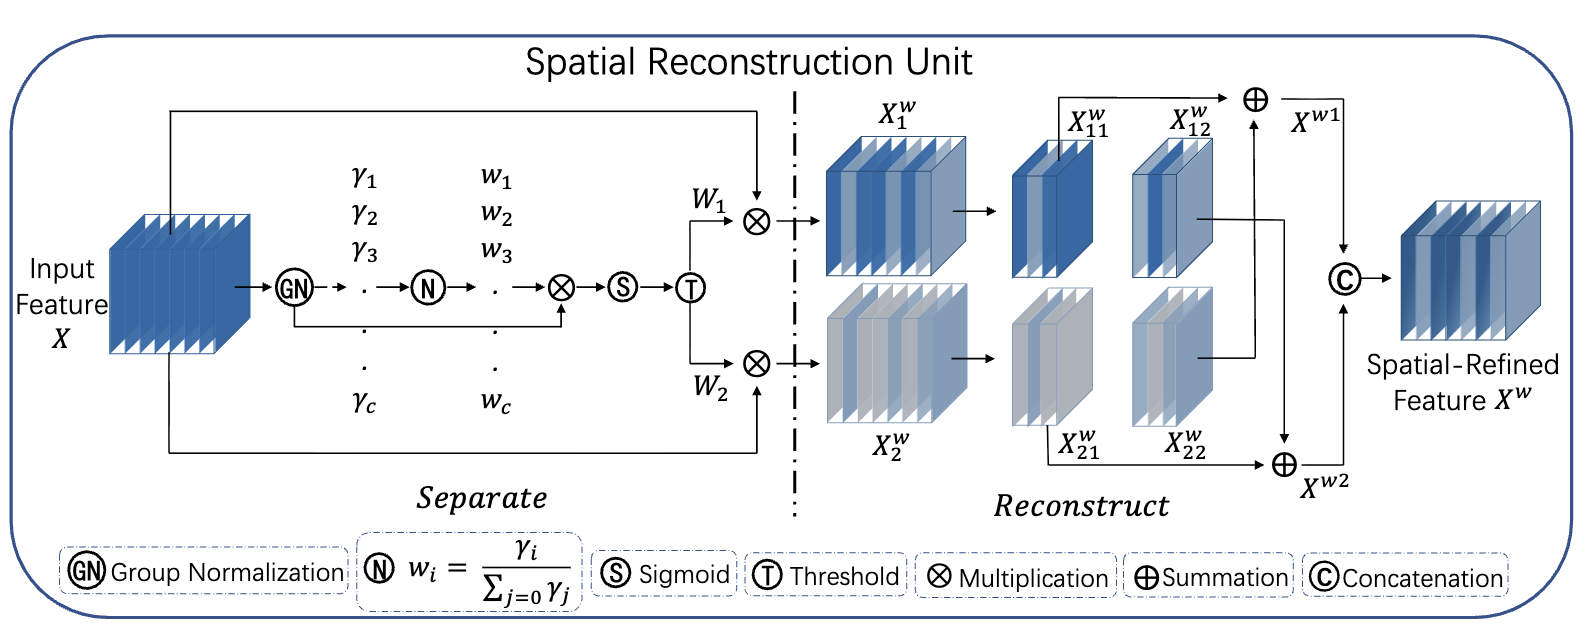

In [ ]:
class SRU(nn.Module):
    # separate and reconstruct
    def __init__(self, in_channels, group_num, gate_threshold):
        super().__init__()
        self.gn = nn.GroupNorm(num_groups=group_num, num_channels=in_channels)
        self.gate_threshhold = gate_threshold
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # group normalize X -> new_weight = sigmoid(normalized(gn(X))) -> separate by threshhold
        gn_x = self.gn(x)
        gamma = self.gn.weight
        w_gamma = gamma / (sum(gamma) + 1e-5)  # add a small eps for division
        w_gamma = w_gamma.view(1, -1, 1, 1)  # match the input x dimension
        new_weight = self.sigmoid(gn_x * w_gamma) # 以 normalize * gamma

        # set masks
        mask_info = (new_weight >= self.gate_threshhold).float()
        mask_non_info = (new_weight < self.gate_threshhold).float()

        # separate
        x_w_1 = mask_info * x
        x_w_2 = mask_non_info * x

        # reconstruct
        # torch.chunk(input: Tensor, chunks: int, dim: int = 0)
        # 交叉中和掉特徵，比起直接把不重要的特徵全部丟掉好
        # chunk=2 等於 把原本的 channel 分成 2 部分
        # dim=1 等於把 feature map 從厚度上分成兩半
        # dim=2 等於把 feature map 分成上下兩半
        # example:
        # chunk=2 dim=1 -> 不動原來的圖，分成兩份
        # chunk=2 dim=2 -> 把原來的圖上下對切，分成兩份
        # chunk=4 dim = 2 -> 把原來的圖上下對切，分成 4 份

        # 結構
        # Tensor -> Channel(feature map)(切片) -> Feature vector(長棍)
        # Tensor: C*H*W, Channel: H*W (in pixels),  Feature vec: C
        # dim = 1 to split chennal dimension
        x_w_11, x_w_12 = torch.chunk(x_w_1, 2, dim=1)
        x_w_21, x_w_22 = torch.chunk(x_w_2, 2, dim=1)

        x_w1 = x_w_11 + x_w_22
        x_w2 = x_w_12 + x_w_21

        # torch.cat(tensors, dim=0, *, out=None) → Tensor
        # torch.cat() can be seen as an inverse operation for torch.split() and torch.chunk().
        # 所以確保 dim 一樣就可以直接使用 cat 還原剛剛被 chunk 的圖
        out = torch.cat([x_w1, x_w2], dim=1) # dim=1 確保最後厚度一樣
        return out

### CRU

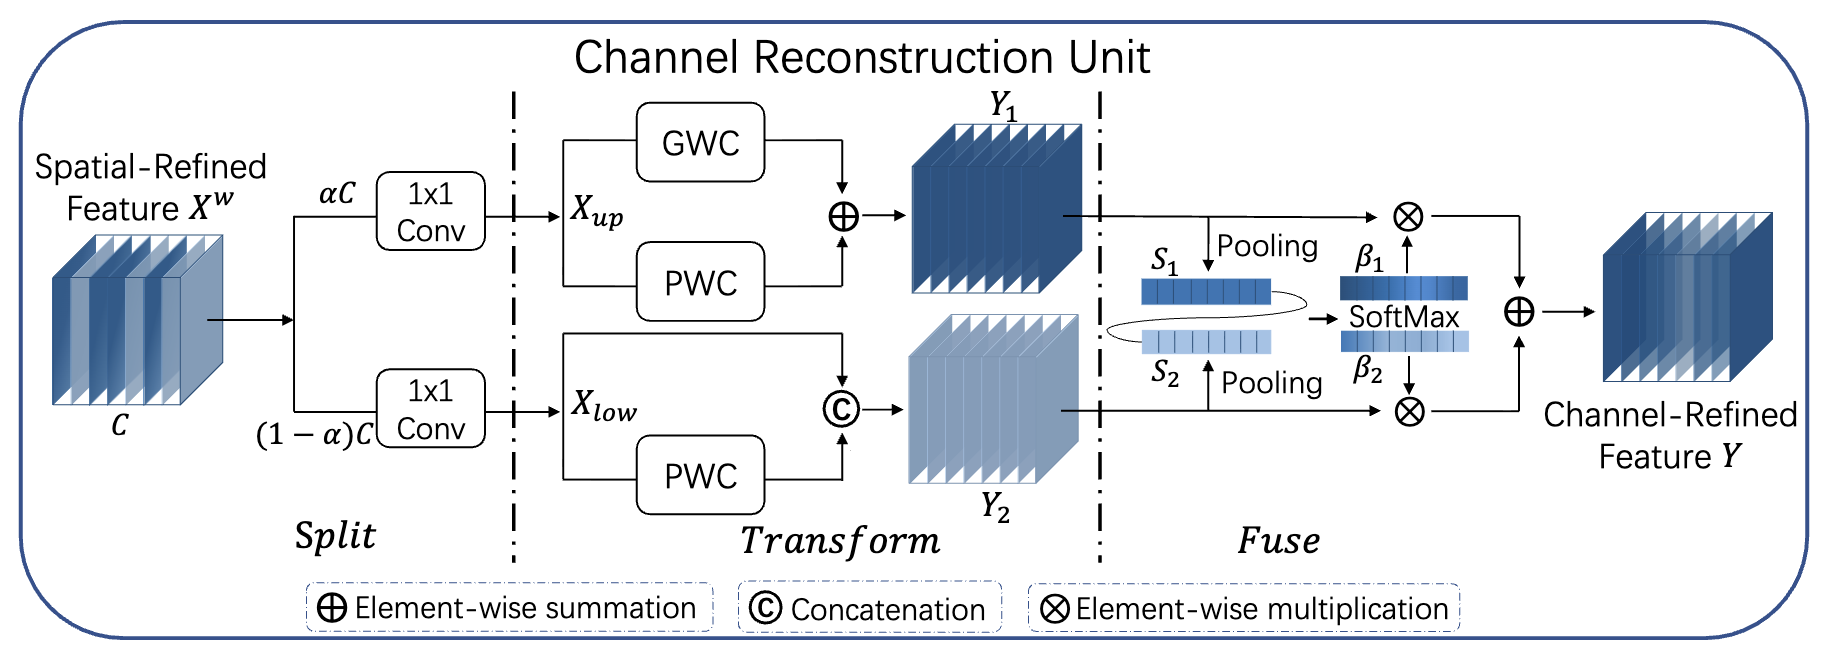

In [ ]:
class CRU(nn.Module):
    def __init__(self, in_channels, out_channels, alpha, r,
                group_size, kernel_size):  # alpha = split ratio, r = sqeeze ratio
        super().__init__()

        # separate
        self.upper_channels = int(alpha * in_channels)
        self.lower_channels = in_channels - self.upper_channels

        self.upper_squeez_channels = int(self.upper_channels / r)
        self.lower_squeez_channels = int(self.lower_channels / r)

        # CHECK if the channel size is applicable
        if out_channels - self.lower_squeez_channels < 0:
            print("Please Adjust the Alpha and Squeeze Ratio in CRU to satisfy channel constraint in lower part")
            exit()

        # upper conv
        self.upper_conv1 = nn.Conv2d(self.upper_channels, self.upper_squeez_channels, kernel_size=1) # for getting X_up
        self.upper_gwc = nn.Conv2d(self.upper_squeez_channels, out_channels, kernel_size=kernel_size,
                                   padding=kernel_size//2, groups=group_size)
        self.upper_pwc = nn.Conv2d(self.upper_squeez_channels, out_channels, kernel_size=1)

        # lower conv
        self.lower_conv1 = nn.Conv2d(self.lower_channels, self.lower_squeez_channels, kernel_size=1) # for getting X_low
        # NOTE!!! WE HAVE TO HANDLE THE CASE OF C2 <= (1-alpha)C1/r
        # Which will happen in DenseNet because the bottleneck layer is 128 --> 32
        # if alpha is 0.5 and r is 2, we have lower_squeez_channels = 32, which makes the lower_pwc have 0 channel output
        if out_channels - self.lower_squeez_channels == 0:
            self.lower_pwc = None
        else:
            self.lower_pwc = nn.Conv2d(self.lower_squeez_channels, out_channels - self.lower_squeez_channels, kernel_size=1)

        # element-wise summation
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # basically means AvgPool2d(out_channels)

    def forward(self, x):
        # split channels
        x_upper, x_lower = torch.split(x, [self.upper_channels, self.lower_channels], dim=1)

        # 1*1 conv to squeeze
        x_upper_squeeze = self.upper_conv1(x_upper)
        x_lower_squeeze = self.lower_conv1(x_lower)

        # transform
        # For upper part
        y_upper = self.upper_gwc(x_upper_squeeze) + self.upper_pwc(x_upper_squeeze)
        # For lower part
        # HANDLE THE C2 <= (1-alpha)C1/r CASE
        if self.lower_pwc is None:
            y_lower = x_lower_squeeze
        else:
            y_lower = torch.cat([self.lower_pwc(x_lower_squeeze), x_lower_squeeze], dim=1)

        # Fuse
        s1 = self.global_avg_pool(y_upper)
        s2 = self.global_avg_pool(y_lower)

        # s1 ans s2 are in dimension of [N, C, 1, 1]
        # in order to do pair wise siftmax between s1 and s2
        # we first stacj them into [N, C, 1, 1, 2] tensor
        s_stacked = torch.stack([s1, s2], dim=-1)
        # apply softmax pairwise
        s_final = torch.softmax(s_stacked, dim=-1)
        # separate it back into 2 [N, C, 1, 1] tensors
        beta1 = s_final[... , 0]
        beta2 = s_final[... , 1]

        final_y_upper = y_upper * beta1
        final_y_lower = y_lower * beta2

        final_y = final_y_upper + final_y_lower

        return final_y

### SCConv and its Model Params (Unsure about group number in SRU)

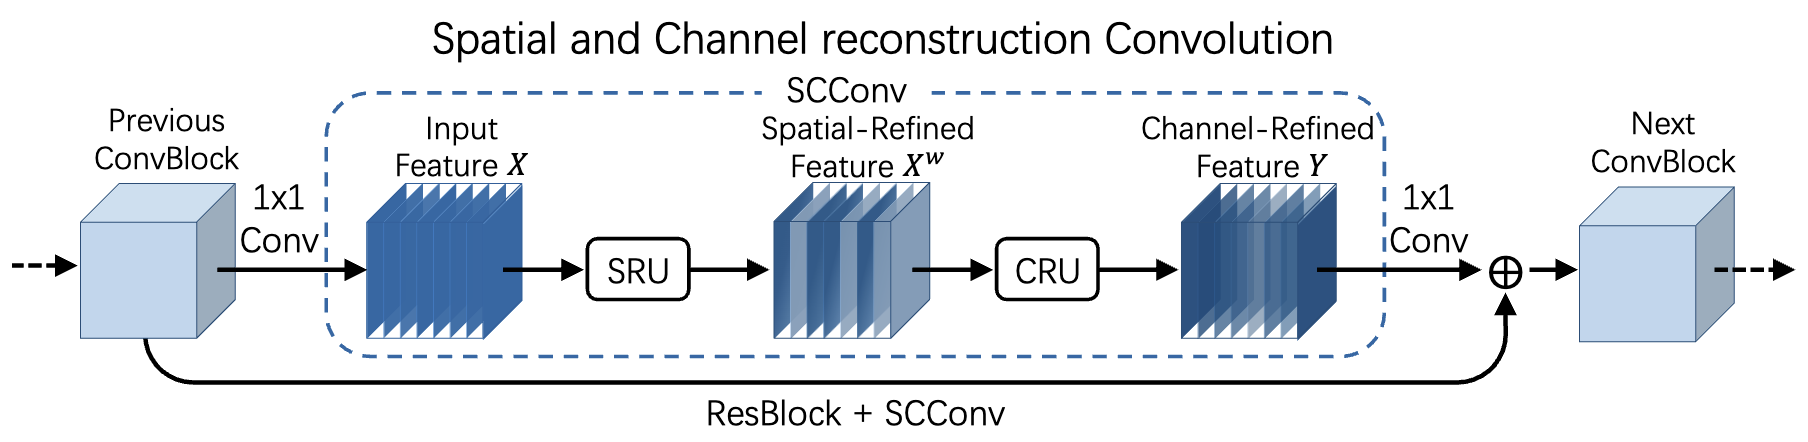

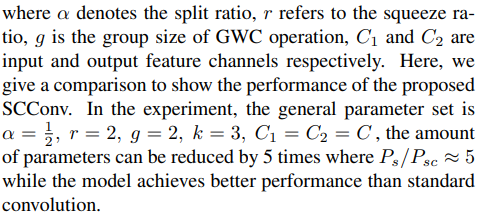

In [ ]:
class SCConv(nn.Module):
    def __init__(self, in_channels, out_channels, target_stride=1):
        super().__init__()
        # define paper's Hyper params
        self.SRU_NUM_GROUP = in_channels // 2  # Unsure...
        self.SRU_THRESHOLD = 0.5
        self.CRU_ALPHA = 0.5
        self.CRU_SQUEEZE_R = 2
        self.CRU_NUM_GROUP = 2
        self.CRU_KERNEL_SIZE = 3

        self.sru = SRU(in_channels, group_num=self.SRU_NUM_GROUP, gate_threshold=self.SRU_THRESHOLD)
        self.cru = CRU(in_channels, out_channels, alpha=self.CRU_ALPHA, r=self.CRU_SQUEEZE_R,
                       group_size=self.CRU_NUM_GROUP, kernel_size=self.CRU_KERNEL_SIZE)

        # We use AvgPool2d with kernel=2, stride=2 to halve width/height
        if target_stride == 2:
            self.downsample = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.downsample = nn.Identity() # Do nothing

    def forward(self, x):
        x = self.downsample(x)
        x = self.sru(x)
        x = self.cru(x)
        return x

### Finish SCConv settings, Test the correctness

In [ ]:
from torchsummary import summary

def test_scconv():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # [Batch, Channel, Height, Width], batch 等於圖量
    input_tensor = torch.randn(1, 64, 32, 32).to(device)
    scconv = SCConv(64, 64).to(device)
    output_tensor = scconv(input_tensor)
    print(f"Input Shape: {input_tensor.shape}")
    print(f"Output Shape: {output_tensor.shape}")

    # Straightly simulate with the input data
    summary(scconv, (64, 32, 32))

    # print out structure
    print(scconv)

test_scconv()

### Create DenseNet 121 and replace each bottleneck layer (**NOTE! [`handle_stride_2`](https://discord.com/channels/1434225562519601254/1434226756222582844/1443254573178556447) is set here**)

Actually... DenseNet has no bottleneck layer that has a stride of 2, so we don't need to worry about `handle_stride_2`

In [ ]:
# Define the replacement function
def replace_layers(model, handle_stride_2=True):
    # Iterate over the main feature extractor
    # model.features contains: conv0, norm0, pool0, denseblock{i}, transition{i}
    for block_name, block in model.features.named_children():
        # We only want to enter 'denseblock' modules
        if "denseblock" in block_name:
            # Now iterate over the layers inside the block (denselayer1, denselayer2...)
            for layer_name, layer in block.named_children():
                # Check if the layer has the attribute 'conv2'
                if hasattr(layer, 'conv2'):
                    old_conv = layer.conv2

                    # Create new SCConv layer
                    # We pass the old parameters to ensure shapes match
                    new_sc_conv = SCConv(
                        in_channels=old_conv.in_channels,
                        out_channels=old_conv.out_channels,
                    )

                    # Replace the attribute
                    layer.conv2 = new_sc_conv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start from a fresh ResNet
SCConv_D121 = models.densenet121(weights=None)  # load from scratch
SCConv_D121.classifier = nn.Linear(SCConv_D121.classifier.in_features, 101)  # for Food-101

# NO NEED to change handle_stride_2
replace_layers(SCConv_D121)

SCConv_D121 = SCConv_D121.to(device)

print("Using device:", device)

### More settings

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(
    SCConv_D121.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=LR_MILESTONES,
    gamma=LR_GAMMA
)

criterion = nn.CrossEntropyLoss()

### Model Metrices (FLOPS, Params...)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Straightly simulate with the input data to see Params count
summary(SCConv_D121, (1, 3 ,224 ,224))

In [ ]:
# model structure
print(SCConv_D121)

In [ ]:
!pip install thop

In [ ]:
# FLOPS
def evaluate_model_complexity(model, input_size=(1, 3, 224, 224), device='cuda'):
    """
    評估模型的參數量與計算量 (FLOPs)。
    需安裝 thop: pip install thop
    """
    try:
        from thop import profile, clever_format
    except ImportError:
        print("Error: 'thop' library is not installed. Please run: pip install thop")
        return

    model = model.to(device)
    model.eval()

    dummy_input = torch.randn(input_size).to(device)

    # 計算 FLOPs 和 Params
    flops, params = profile(model, inputs=(dummy_input, ), verbose=False)

    # 格式化輸出
    flops_fmt, params_fmt = clever_format([flops, params], "%.3f")

    print("="*40)
    print(f"FLOPs Evaluation")
    print(f"Input Shape: {input_size}")
    print(f"FLOPs: {flops_fmt}")
    print("="*40)

    return flops, params

evaluate_model_complexity(SCConv_D121, input_size=(1, 3, 224, 224), device=device)

# 🌟Start Training!

### Define functions for training / evaluating w.r.t 1 epoch

In [ ]:
from tqdm.auto import tqdm

# Getting Acc in a batch
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Train an epoch
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        # Reset gradients from the previous iteration (avoid accumulation)
        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        # Optimizer step: update parameters using computed gradients
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluate an epoch
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training functions

In [ ]:
def train_model(model, train_iterator, test_iterator, device,
                optimizer, scheduler, criterion,
                epochs=EPOCHS, model_path='Best-SCConv-D121-Food101.pt'):

    model = model.to(device)

    best_valid_loss = float('inf')

    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    learning_rates = []

    for epoch in tqdm(range(epochs)):
        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, test_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)

        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        current_lr = optimizer.param_groups[0]['lr']

        # Decaying after an Epoch
        scheduler.step()

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR: {current_lr:.5f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        learning_rates.append(current_lr)

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'valid_losses': valid_losses,
        'valid_accuracies': valid_accuracies,
        'learning_rates': learning_rates,
        'best_model_path': model_path
    }

### Training Begins!!!!!

In [ ]:
trained_model = SCConv_D121.to(device)

# call the train method
trained_stats = train_model(
    model=trained_model,
    train_iterator=train_iterator,
    test_iterator=test_iterator,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
)

torch.save(trained_stats, 'trained_stats_SCConv-D121_Food101.pt')

# 🌟Evaluation Time

In [ ]:
# # Reload the model (Optional)
# trained_model = SCConv_D121
# trained_model.load_state_dict(torch.load('Best-SCConv-D121-Food101.pt'))

# trained_stats = torch.load('trained_stats_SCConv-D121_Food101.pt', map_location=device)

### The Loss and Accuracy Curve

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(trained_stats):
    epochs_to_show = EPOCHS
    epochs = range(1, epochs_to_show + 1)

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, trained_stats["train_losses"][:epochs_to_show], label='Train Loss')
    plt.plot(epochs, trained_stats["valid_losses"][:epochs_to_show], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, [acc * 100 for acc in trained_stats["train_accuracies"][:epochs_to_show]], label='Train Accuracy')
    plt.plot(epochs, [acc * 100 for acc in trained_stats["valid_accuracies"][:epochs_to_show]], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_and_accuracy(trained_stats)

### The Most Incorrect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

def plot_most_incorrect(trained_model, test_iterator, device, n_images=16, class_names=None):
    trained_model.eval()

    # Use a min-heap to keep only top N incorrect examples
    # Format: (confidence, index, image, true_label, probs)
    # We use negative confidence for max-heap behavior
    incorrect_heap = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_iterator):
            x = x.to(device)
            y_pred = trained_model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            # Move to CPU immediately and process
            y_prob_cpu = y_prob.cpu()
            y_cpu = y.cpu()
            x_cpu = x.cpu()

            pred_labels = torch.argmax(y_prob_cpu, 1)

            # Process each image in the batch
            for i in range(x_cpu.size(0)):
                if pred_labels[i] != y_cpu[i]:
                    # Get the confidence of incorrect prediction
                    incorrect_prob = y_prob_cpu[i, pred_labels[i]].item()

                    # Use negative for max-heap behavior with heapq (min-heap)
                    item = (-incorrect_prob, batch_idx * len(x) + i,
                           x_cpu[i].clone(), y_cpu[i].item(), y_prob_cpu[i].clone())

                    if len(incorrect_heap) < n_images:
                        heapq.heappush(incorrect_heap, item)
                    elif -incorrect_prob > incorrect_heap[0][0]:
                        heapq.heapreplace(incorrect_heap, item)

            # Clear batch from memory
            del x, y_pred, y_prob, y_prob_cpu, y_cpu, x_cpu

    # Sort by confidence (descending)
    incorrect_examples = sorted(incorrect_heap, key=lambda x: x[0])

    # Plot results
    rows = int(np.sqrt(n_images))
    cols = int(np.ceil(n_images / rows))

    fig = plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i in range(min(len(incorrect_examples), rows * cols)):
        ax = fig.add_subplot(rows, cols, i + 1)

        _, _, image, true_label, probs = incorrect_examples[i]
        true_prob = probs[true_label].item()
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        incorrect_prob = incorrect_prob.item()
        incorrect_label = incorrect_label.item()

        # Prepare image for display
        img = image.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        # Set title
        if class_names:
            title = f'True: {class_names[true_label]} ({true_prob:.2f})\nPred: {class_names[incorrect_label]} ({incorrect_prob:.2f})'
        else:
            title = f'True: {true_label} ({true_prob:.2f})\nPred: {incorrect_label} ({incorrect_prob:.2f})'

        ax.set_title(title, fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_most_incorrect(trained_model, test_iterator, device, 16, class_names=trainset.classes)

### The final loss and accuracy

In [ ]:
test_loss, test_acc = evaluate(trained_model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

### Display Feature Maps (TODO)